In [1]:
import numpy as np
import os
import sys
import random
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/experiments")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAEDSprites, Discriminator
from beta_vae import Classifier
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_factor_vae, test_factor_vae
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae
from utils import load_checkpoint_factorvae, save_checkpoint_factorvae

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device.type

'cpu'

In [3]:
def plot_loss(loss_lists, title):
    if not isinstance(loss_lists[0], list):
        loss_lists = [loss_lists]
    for loss_list in loss_lists:
        plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

In [4]:
dataset = load_dsprites("../datasets/dsprites.npz",False)

In [5]:
data_size = 1000
data_ = CustomDSpritesDatasetFactorVAE(dataset,data_size,seed=2)

In [6]:
data_train, data_test = train_test_random_split(data_, 0.8, seed=2)
print("Training : "+str(len(data_train)))
print("Testing : "+str(len(data_test)))

Training : 800
Testing : 200


In [7]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)

In [8]:
model = FactorVAEDSprites()
model.to(device)
discriminator = Discriminator(nb_layers=4,hidden_dim=500)
discriminator.to(device)
vae_optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)
discriminator_optimizer = torch.optim.Adagrad(discriminator.parameters(), lr=1e-2)
save_checkpoint_factorvae(model,discriminator,vae_optimizer,discriminator_optimizer,"checkpoint.pth.tar",0)
model, discriminator, vae_optimizer, discriminator_optimizer, start_epoch = load_checkpoint_factorvae(model, discriminator, vae_optimizer, discriminator_optimizer, filename='checkpoint.pth.tar')
gamma = 10
epochs = 5

=> loading checkpoint 'checkpoint.pth.tar'
=> loaded checkpoint 'checkpoint.pth.tar' (epoch 1)


In [9]:
train_losses_list, recon_losses_list, kl_divs_list, tc_losses_list, discriminator_losses_list = train_factor_vae(model, discriminator, epochs, train_loader, vae_optimizer, discriminator_optimizer, gamma, 'bernoulli',device=device)

/Users/ireneburger/opt/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: 2859.342247596154, recon loss: 1722.3368530273438, kl div: 1264.077765775737, TC loss: -12.707231517021473, discriminator loss: 8.77028430195955
Epoch 1 finished, loss: 775.981703538161, recon loss: 773.2626436673678, kl div: 2.6879035463699927, TC loss: 0.0031147241019285643, discriminator loss: 0.7796657635615423
Epoch 2 finished, loss: 632.5504056490385, recon loss: 630.8393272986779, kl div: 1.6571873609836285, TC loss: 0.005389562879617398, discriminator loss: 0.7062346018277682
Epoch 3 finished, loss: 616.6463576096755, recon loss: 612.8966792179988, kl div: 2.2476033981029806, TC loss: 0.15020675355425248, discriminator loss: 0.7518962117341849
Epoch 4 finished, loss: 546.7407015286959, recon loss: 537.8778921274038, kl div: 5.579765558242798, TC loss: 0.32830440310331493, discriminator loss: 0.6844909741328313


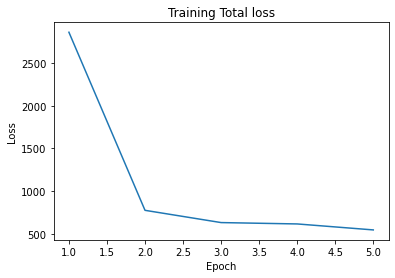

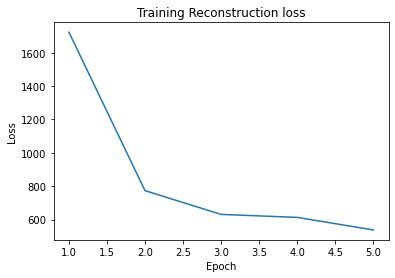

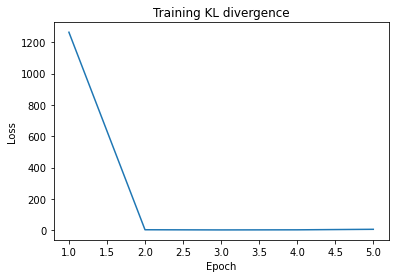

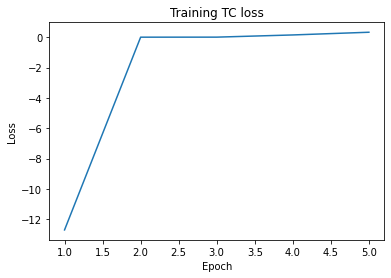

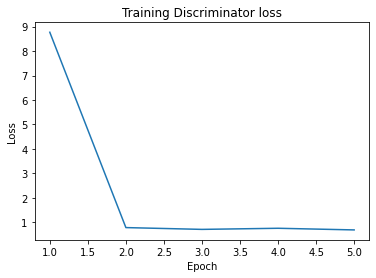

In [10]:
plot_loss(train_losses_list, "Total loss")
plot_loss(recon_losses_list, "Reconstruction loss")
plot_loss(kl_divs_list, "KL divergence")
plot_loss(tc_losses_list, "TC loss")
plot_loss(discriminator_losses_list, "Discriminator loss")

In [11]:
test_factor_vae(model, discriminator, test_loader, gamma, 'bernoulli', device=device)

Test loss: 510.2261734008789
Test recon loss: 501.43470001220703


/Users/ireneburger/opt/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


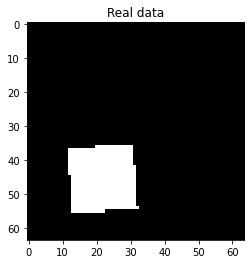

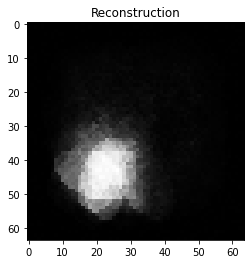

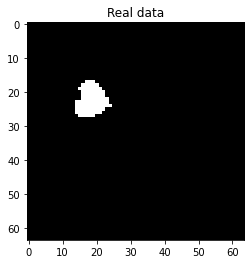

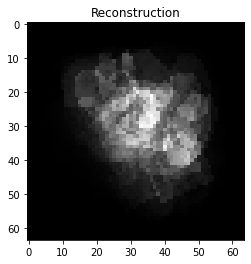

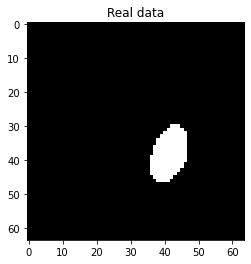

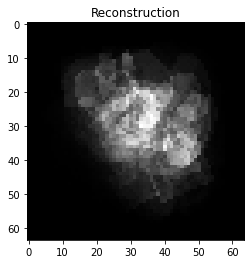

In [12]:
with torch.no_grad():
    for i in [1,2,20]:
        data, _ = data_test[i]
        data = data.float()
        if device != None:
            data = data.to(device)
        recon, mu, logvar, z = model(data)
        plt.imshow(data.cpu(), cmap='Greys_r')
        plt.title("Real data")
        plt.show()
        plt.imshow(torch.sigmoid(recon.squeeze().cpu()), cmap='Greys_r')
        plt.title("Reconstruction")
        plt.show()


Factor Vae metric: 
accuracies : [0.3833333333333333, 0.39, 0.3533333333333334, 0.3566666666666667, 0.33333333333333337]
[[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
  [ 3.2  4.2  0.4 15.4  2.   3.2 10.4  0.   3.2 19. ]
  [ 7.2  9.4  0.2 29.6  0.   2.2  1.2  0.   0.2  7. ]
  [ 3.8  3.6  0.   9.6  0.6  3.2 13.   0.   3.8 26.4]
  [ 1.2  4.8  1.6  0.  12.8  0.  11.4  0.   4.  17.4]
  [ 0.2 11.2  0.4  6.4  3.4  9.6 13.2  0.  11.2  9.2]]]
Accuracy: 0.3633333333333334
Beta Vae metric: 
Accuracy: 0.39


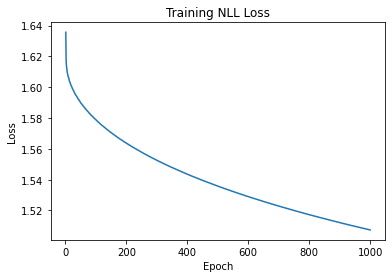

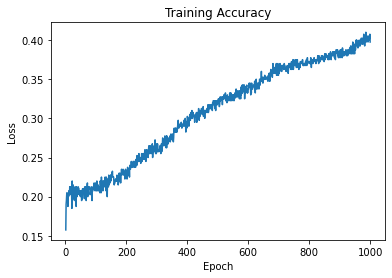

In [14]:
print("Factor Vae metric: ")
loss = entanglement_metric_factor_vae(model, data_, 300, 200, random_seeds=5,seed=2)
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adagrad(classifier.parameters(), lr=1e-2)
train_losses, train_accuracies, test_accuracy = entanglement_metric_beta_vae(model, classifier, optimizer, 1000,  data_, 500, 50, random_seeds=1,seed=2)
print("Accuracy: "+str(test_accuracy))
plot_loss(train_losses, "NLL Loss")
plot_loss(train_accuracies, "Accuracy")